## Wordcloud of top words from tweets

The following script finds the most frequent words in a set of tweets and creates a wordcloud of those words. The more often a term is used, the larger the word is in the wordcloud. Many times wordcloud analyses are used to see word frequencies in relation to eachother, but this particular script strips out stopwords so the resulting words shed light on recuring themes.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Intro/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.         

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:   


- **nltk:** Platform for building Python programs to work with human language data.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers: dict, list, set, and tuple.

- **wordcloud:** A simple wordcloud generator in Python.

- **PIL:** Stands for Python Imaging Library and adds image processing capabilities.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

- **numpy:** The fundamental package for scientific computing with Python.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **csv:** Implements classes to read and write tabular data in CSV format.
- **json:** Allows for handling of data in JSON format.
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [2]:
from nltk.corpus import stopwords
import string
from collections import defaultdict
import wordcloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import json
import pandas as pd

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We are doing this so you will not need to make changes in the code further down.

First we need to specify what file type our data is saved as. Generally when dealing with Twitter data it will be in either ".json" or ".csv" format. For this reason our notebook will only read in ".csv" or ".json" files. The first variable `fileType` is where you choose either ".csv" or ".json" for your `fileType`. So it should look like `fileType = ".csv"` or `fileType = ".json"`.

Your data can be contained in one file or many. Therefore, you need to state if you want to read in a single document or an entire directory. If you want to read in a single document, then set `singleDoc` equal to **True**. If you want to read in an entire directory of documents then set `singleDoc` equal to **False**.

The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

The `customStop` variable is for if you have a dataset that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do **NOT** need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

The `stopLang` variable is to choose the language of the nltk stopword list you wish to use. It is currently set to `"english"`. If you need a different language, simply change `"english"` to the anglicized name of the language you wish to use (e.g. "spanish" instead of "espanol" or "german" instead of "deutsch"). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` and run the cell. A list of available languages will display below the cell. 

The `stopWords = []` is an empty list that will contain the final list of stop words to be removed form your dataset. What ends up in the list depends on whether you set `nltkStop` and/or `customStop` equal to **True** or **False** and if you add any additional words to the list.

In [3]:
fileType = ".csv"
singleDoc = True
nltkStop = True
customStop = False
stopLang = "english"
stopWords = []

#print(" ".join(stopwords.fileids()))

#### File paths
Here we are saving different file paths as variables that we need in our code. We again do this so you will not need to make as many changes to the code later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one, or we may need to access a file in this directory, but need to navigate to another folder to access other data. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names for the output in the appropriate cells down below. We save this file path as the variable `dataResults`.

Lastly, we use the file path from `dataHome` to point to the directory where our data is stored and save that as `dataRoot`. Notice though that this is dependent upon whether you chose `".json"` or `".csv"` as your `fileType` above.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
if fileType == ".csv":
    dataRoot = os.path.join(dataHome, "twitter", "CSV")
else:
    dataRoot = os.path.join(dataHome, "twitter", "JSON")

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`. You should already have chosen your language above, so there is no need to do that here.

If you wish to add additional words to the `stopWords` list, add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))
    
    stopWords.extend(['amp','rt', 'xo_karmin_ox', 'neveragain', 'ð', 'â', 'ï', 'emma4change'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in "customStop" above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct path order, always putting the file name including the file extension ('.txt') last.        

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(dataHome, "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning
The first function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Next we remove URLs by removing any text that starts with 'http' and ending with a space. Then we split the text into individual words. Next we remove any empty space, digits, stopwords, and punctuation. Finally, we return a list of cleaned words.

In [7]:
def textClean(text):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stopWords]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

#### Plot wordcloud

Now we need a function that creates a wordcloud based on word frequency and plots it. To start we name the needed parameters which includes the words (`tokens`), the file path where we want to save the resulting visualization (`wcImgFilepath`), the dpi quality of the result (`dpi`), the maximum amount of words we want the wordcloud to show (`maxWordCnt`), and if we have a special shape we want the wordcloud to take (`maskFilepath`). The default for `maskFilepath` is **None**.

The statements to execute begin by determining the word frequency and then what to do regarding the shape of the wordcloud. The wordcloud package uses an image file which is refered to as a mask to determine the shape. If a mask is not given then the resulting wordcloud will be in a rectangular shape. Next we need to describe the aesthetics of the wordcloud such as background color, maximum number of words, the mask shape, and color scheme of the wordcloud. We do this using functions and parameters from the wordcloud package and saving them as the variable `wc` for wordcloud. In this line the `colormap =` part is probably the only part you might want to change. The current color is from the RColorBrewer palette of colors. You can find other color options [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf). Just put the name of the color selection you want in quotes.

Next we need to generate the wordcloud and make sure it is generated using word frequency and displays the words, not the frequency (`wc.fit_words(freq)`). 

Then are the statements for how the wordcloud is displayed, so first we state the figures size (`plt.figure(figsize = (60,20))`). Then we want it to look like what we described in our 'wc' variable above it (`plt.imshow(wc, interpolation = 'bilinear')`), and that we are not using an x or y axis (`plt.axis("off")`). Next we want the layout to be tight instead of spread out (`plt.tight_layout()`). Then we state arguments for how we want the wordcloud saved to file (`plt.savefig(wcImgFilepath, format = 'png', dpi = dpi, bbox_inches = 'tight')`), and finally that we want to see the final result displayed in the notebook (`plt.show()`).

In [8]:
def plotWordCloud(tokens, wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):

    freq = defaultdict(int)

    for t in tokens:
        freq[t] += 1
        
    if maskFilepath is not None:
        mask = np.array(Image.open(maskFilepath))
    else:
        mask = None

    wc = wordcloud.WordCloud(background_color = "white", max_words = maxWordCnt, mask = mask, colormap = 'Dark2')
    

    # generate word cloud
    wc.fit_words(freq)

    # store to file
    wc.to_file(wcImgFilepath)

    # show
    plt.figure(figsize = (60, 20))
    plt.imshow(wc, interpolation = 'bilinear')
    
    plt.axis("off")

    plt.tight_layout()
    
    # save graph as a png image to file
    plt.savefig(wcImgFilepath, format = 'png', dpi = dpi, bbox_inches = 'tight')
    plt.show()

#### Read a .csv file

This function gives parameters and statements for how to read a '.csv' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".csv"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are incluidng that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we tell Python to seperate the lines using a comma as the delimiter. Next we add the lines as rows in a column. Finally, we return the the content starting with row 1, not row 0, as row 0 is the header.  

In [9]:
if fileType == ".csv":
    def readTweets(filepath, textColIndex, encoding = 'utf-8', errors = 'ignore'):

        with open(filepath, encoding = encoding, errors = errors) as f:

            reader = csv.reader(f, delimiter = ',', quotechar = '"')

            content = []
            for row in reader: 
                content.append(row[textColIndex])

            # skip header
            return content[1 : ]

#### Read a .json file

This function gives parameters and statements for how to read a '.json' file. First notice we have an `if` statement to start. This function will only be saved to memory if we specified our `fileType` as `".json"` above. Otherwise it will go on to the next cell of code.

As far as the function, we are incluidng that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters. This is needed for social media due to the use of emojis and other abnormal characters. Then we use the `loads` function form the `json` package. This will read in the '.json' file content as a string and save it to the empty `tweets = []` list. Next we convert the `tweets` list to a pandas database. Then we convert a single column to a list based on what is chosen for the `textColIndex` variable later on in the code. Finally, we return the content starting with row 1, not row 0, as row 0 is the header. 

In [10]:
if fileType == ".json":
    def readTweets(filepath, textColIndex, encoding = 'utf-8', errors = 'ignore'):
        
        with open(filepath, encoding = encoding, errors = errors) as jsonData:
            tweets = []
            for line in jsonData:
                tweets.append(json.loads(line))
        tweet = pd.DataFrame(tweets)
        content = tweet[textColIndex].tolist()

        return content[1 : ]

#### Pull from a single file

This function reads a single file from which we will be counting and ploting the wordcloud. This function opens the file, reads it, adds the new line mark to the end of each row ('\n'.join(content)), so that the cleaning function we created above knows where the end of each line is. It then calls the `textClean` function to clean the text and then calls the `plotWordCloud` function we created above to plot the wordcloud.

In [11]:
def drawWordCloudFromSingleFile(dataFilepath, textColIndex, encoding, errors, 
                               wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):
    
    content = readTweets(dataFilepath, textColIndex, encoding, errors)
    
    text = '\n'.join(content)
    
    tokens = textClean(text)
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt, maskFilepath)
    

#### Pull from a directory

This function reads all files in a directory from which we will be counting and ploting a wordcloud. This function 'walks' through the directory and all sub-directories, ignores hidden files which are designated by the file name beginning with a period. The function then creates a variable that says to include the entire file path for each file in the directory. Then the function opens the file, reads it, adds the new line mark to the end of each row (`text = '\n'.join(content)`), so that the cleaning function we created above knows where the end of each line is. It then calls the `textClean` function we created above. Then the function says to print the file path as soon as the file has been processed so we can see the progress and finally it calls the `plotWordCloud` plotting function we created above.

In [12]:
def drawWordCloudFromScan(dataRoot, textColIndex, encoding, errors, 
                             wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):
   
    tokens = []
    
    for root, subdirs, files in os.walk(dataRoot):
        
        for filename in files:
            
            # skip hidden file
            if filename.startswith('.'):
                continue
            
            dataFilepath = os.path.join(root, filename)
            
            content = readTweets(dataFilepath, textColIndex, encoding, errors)
            text = '\n'.join(content)
            tokens.extend(textClean(text))
                
            print('Finished tokenizing text {}\n'.format(dataFilepath))
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt, maskFilepath)

### Plot Wordcloud

Here we have an 'if else' statement that differentiates between creating a wordcloud from a single document or an entire directory, depending on if you set `singleDoc` above equal to **True** or **False**.

#### First set variables
Before we run the cell below, make sure the variables in the beginning of the notebook are set correctly. The `document` variable should contain the single file you wish to run if you are only interested in a single document. If you set `singleDoc` above to **False** then don't worry about the `document` variable. The `fileType` variable from above is automatically added to the end of the file name, so you do not need to add it. So if your file is named "myFile.csv" you only need to put "myFile" as the ".csv" is automatically added. 

Next we name the output '.png' file produced by the code below. Right now the name is a generic `"wordcloud.png"` but you may wish to change it to something that matches your data.

Then we assign our `textColIndex`, `encoding`, and `errors` variables. The only one you will most likely want to change is the `textColIndex` variable. This will tell both the `drawWordCloudFromSingleFile` and `drawWordCloudFromScan` functions which column in your data to process. You can either name it by index number (remembering to start counting at 0 and not 1) or by the column header for '.json' files, but only by index number for '.csv'. To do it by index number you count from the left beginning with 0 and enter the number of the column you wish to process. If you want the first column, put 0, if the third column, put 2, and so on. If you wish to choose the column by the header, then put the header in quotes and set `textColIndex` equal to that header. It should look like this `textColIndex = 'text'`.  

Now we set our dpi and maximum word count. The `dpi` variable gives the desired resolution of our output image and the `maxWordCnt` gives the maximum number of words we want to appear in our wordcloud.

Lastly, we need to decide if we want to use a mask and have our wordcloud take a particular shape based on an image, or if we just want the basic square wordcloud. The mask uses the contrast of an image (all black against a white background works the best) and places the words only in spots with darker colors. If this sounds like something you would like to do and have an image that can be used as a mask, then set `useMask` equal to **True** and make sure `maskPath` points to where you have your mask image saved. If you do not want to use a mask then simply set `useMask` equal to **False** and do not worry about the `maskPath` variable.

#### From a single text

If you set `singleDoc` above equal to **True**, then the first part of the script in the box below uses the functions and file paths we have created to get word frequencies and plot a wordcloud from a single file. 

We start by pointing to the specific file. 

Next we save the output file based on what we set in the Variables section at the beginning of the cell. 

Then we implement the single file plotting function we created above to give us a wordcloud of most frequent thematic words in our chosen file. If we set `uesMask` equal to **True** then it should be in the shape of the image we used as our mask. If we set `useMask` equal to **False** then it should be a rectangular shaped wordcloud for the output.

#### Wordcloud from multiple files in a directory

If you set `singleDoc` equal to **False**, then the second part of the script in the box below after `else:` now uses the functions and file paths we have created above to get word frequencies and plot a wordcloud from multiple files in a directory. 

We start by saying where we want the output file saved based on our setting in the Variables section at the beginning of the cell.  

Then we implement the directory scan plotting function we created above to give us a wordcloud of most frequent thematic words from our corpus. If we set `uesMask` equal to **True** then it should be in the shape of the image we used as our mask. If we set `useMask` equal to **False** then it should be a rectangular shaped wordcloud for the output.

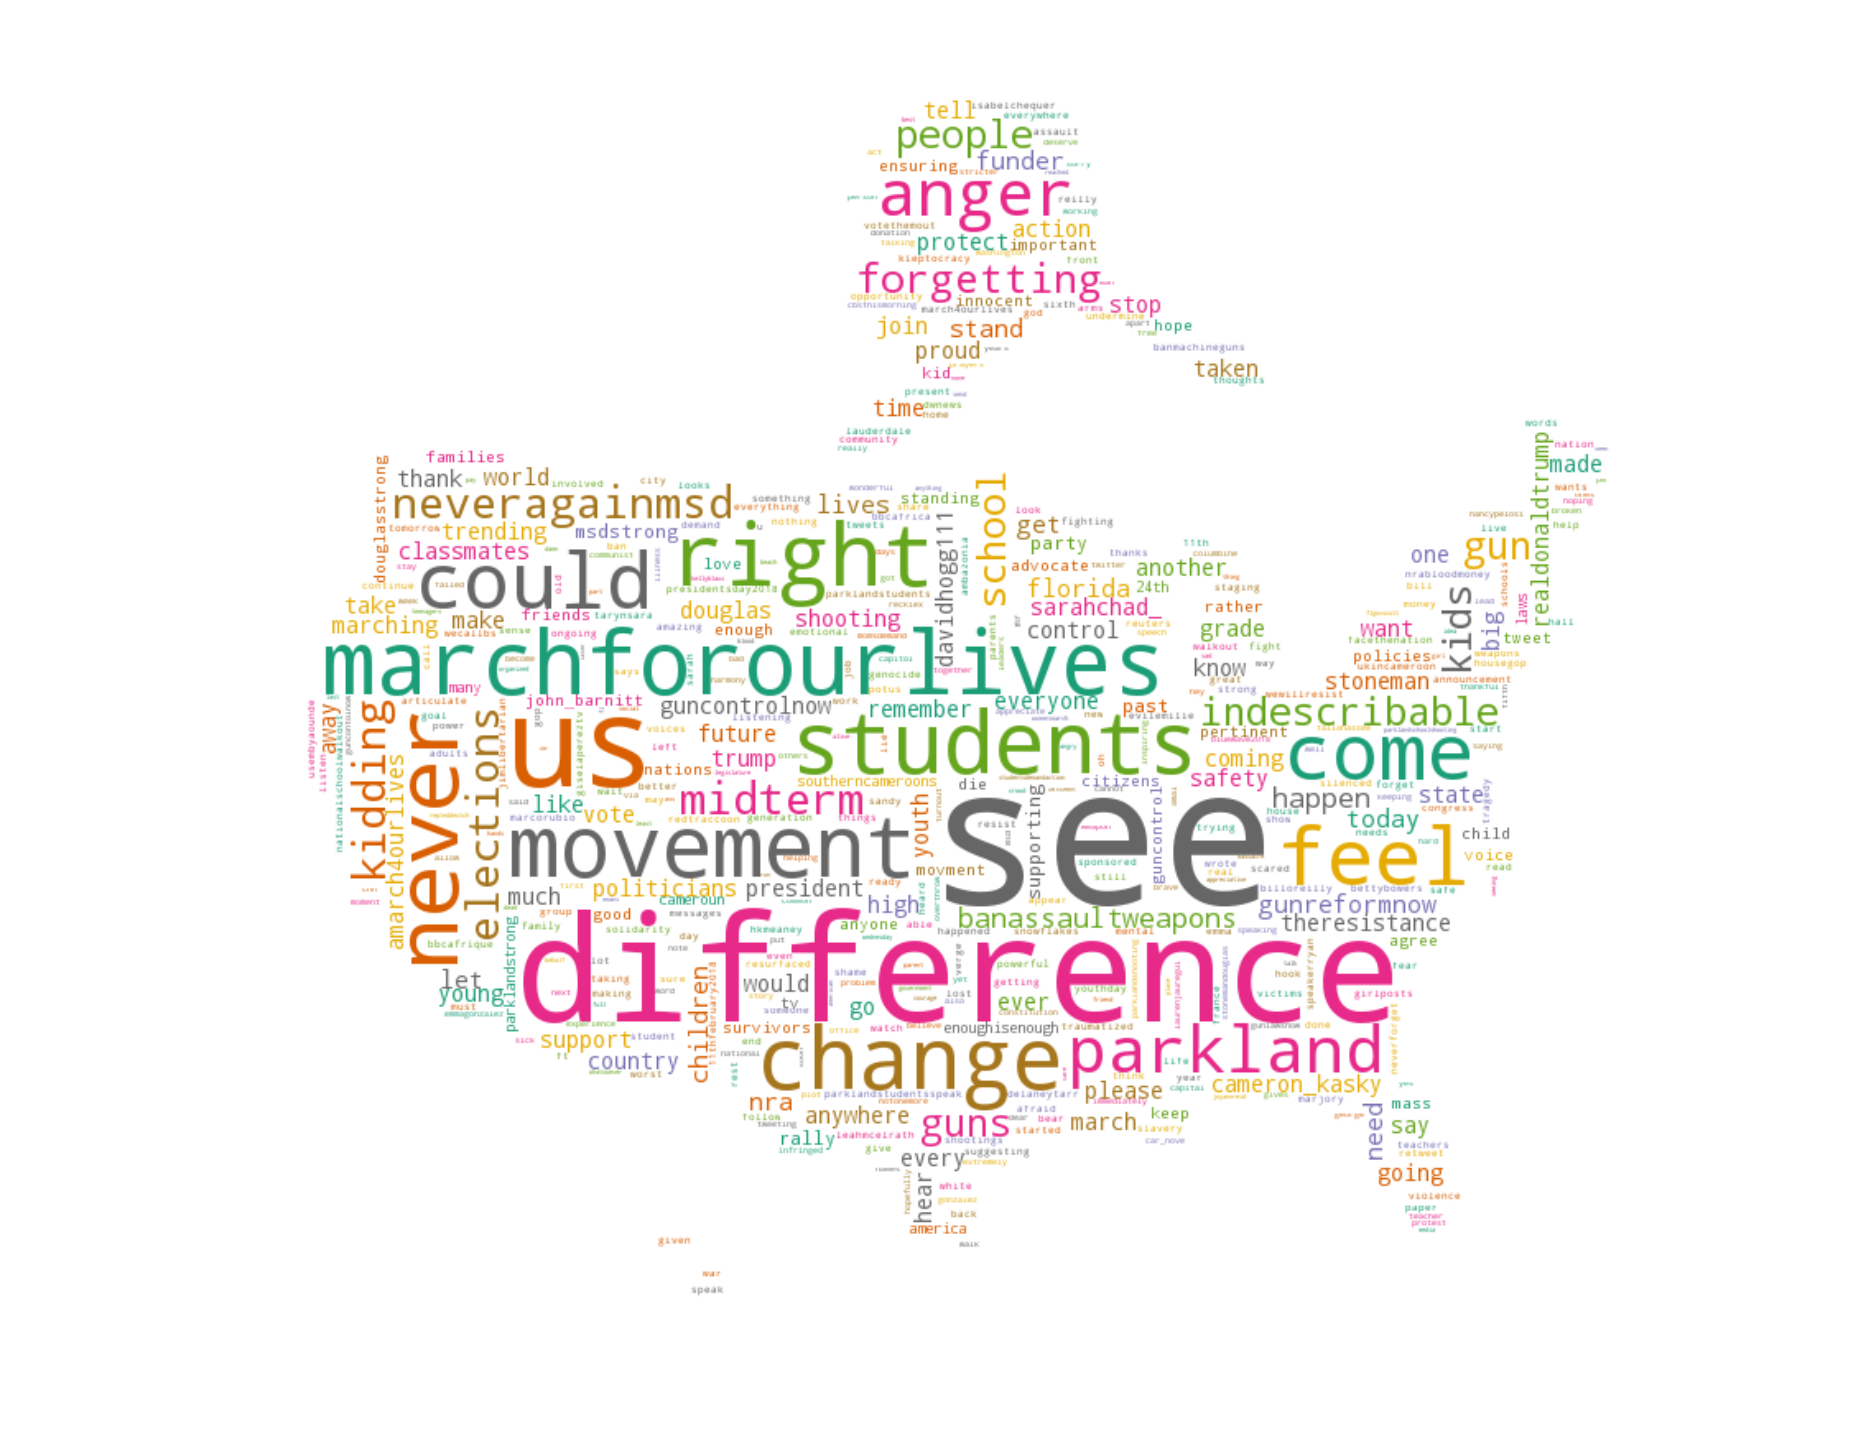

In [13]:
#Variables
document = "neverAgain" + fileType
wcOutputFile = "wordcloud.png"
textColIndex = 2
encoding = 'utf-8'
errors = 'ignore'
dpi = 300
maxWordCnt = 500
useMask = True
maskPath = os.path.join(dataHome,'wordcloudMasks','USA.png')


if singleDoc is True:
    # Use case one, draw word cloud from a single text

    dataFilepath = os.path.join(dataRoot, document)

    # filepath to save word cloud image
    wcImgFilepath = os.path.join(dataResults, wcOutputFile)

    # As an option, user can provision a mask related to the text theme
    if useMask is True:
        
        drawWordCloudFromSingleFile(dataFilepath, textColIndex, encoding, errors, 
                               wcImgFilepath, dpi,  maxWordCnt, maskFilepath = maskPath)
    else:
        maskFilepath = None
        
        drawWordCloudFromSingleFile(dataFilepath, textColIndex, encoding, errors, 
                               wcImgFilepath, dpi,  maxWordCnt, maskFilepath = maskFilepath)
else:
    # Use case two, draw word cloud from a corpus root

    # filepath to save word cloud image
    wcImgFilepath = os.path.join(dataResults, wcOutputFile)

    # As an option, user can provision a mask related to the text theme
    if useMask is True:
        
        drawWordCloudFromScan(dataRoot, textColIndex, encoding, errors, 
                             wcImgFilepath, dpi,  maxWordCnt, maskFilepath = maskPath)
    else:
        maskFilepath = None
        
        drawWordCloudFromScan(dataRoot, textColIndex, encoding, errors, 
                             wcImgFilepath, dpi,  maxWordCnt, maskFilepath = maskFilepath)

## VOILA!!